In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('mwp1_CAT12_DELCODE/Antrag 137_Teipel_Regional Connectivity_20190429_Amendment_MDedit.xlsx', sheet_name='Baseline', header=1)
#print(df)
sid = df['Respeudonym']
grp = df['prmdiag']
age = df['age']
sex = df['sex_bin_1male']
tiv = df['TIV_CAT12']
field = df['FieldStrength']
grpbin = (grp > 0) # 0=CN, ...
amy_bin = df['ratio_Abeta42_40_pos']

In [2]:
# Scan for nifti file names
import glob
dataDELCODE_CN = sorted(glob.glob('mwp1_CAT12_DELCODE/0_CN/*.nii.gz'))
dataDELCODE_MCI = sorted(glob.glob('mwp1_CAT12_DELCODE/2_MCI/*.nii.gz'))
dataDELCODE_AD = sorted(glob.glob('mwp1_CAT12_DELCODE/5_AD/*.nii.gz'))
dataFiles = dataDELCODE_CN + dataDELCODE_MCI + dataDELCODE_AD
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  474  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%s' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]
amy_status = pd.DataFrame({'amy_pos':amy_bin}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('residuals_wb_mwp1_MNI_DELCODE.hdf5', 'r')
hf.keys # read keys
labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
print(images.shape)

Using TensorFlow backend.


(474, 100, 100, 120, 1)


In [5]:
# filter scans by amyloid status
amy_filter = np.equal(np.transpose(amy_status.to_numpy()), labels[:,1])

# drop participants/entries by amy_filter
#dataFiles = [i for (i, v) in zip(dataFiles, np.squeeze(amy_filter)) if v] # filter list of files
#cov_idx = [i for (i, v) in zip(cov_idx, np.squeeze(amy_filter)) if v] # filter list of excel row indices
#labels = labels[np.squeeze(amy_filter), :]
#grps = grps.iloc[np.squeeze(amy_filter)]
#numfiles = len(dataFiles)
#print('Kept ', str(numfiles), ' nifti files')

In [6]:
# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

In [7]:
# specify version of tensorflow
#%tensorflow_version 1.x
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
#print(tf.__version__)

#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
#    # device_count = {'GPU': 1}
#)
#config.gpu_options.allow_growth = False #True
#session = tf.Session(config=config)
#set_session(session)

1.15.0


In [8]:
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((sen * spec) / (sen + spec))
    return sen, spec, ppv, npv, f1

validating model newmodel/newmodel_wb_cv1.hdf5
Test accuracy: 75.00 %


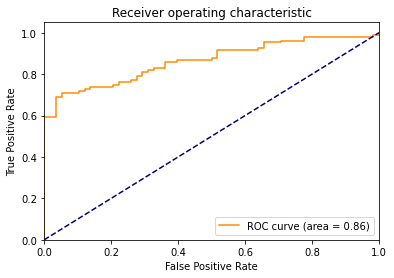

Optimal prediction threshold: 0.99645
Optimal prediction threshold: 0.99721
AUC for MCI vs. CN = 0.81
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.805
AUC for AD vs. CN = 0.933
Acc for MCI vs. CN = 67.0
Acc for AD vs. CN = 72.0
confusion matrix (naive)
[[31 27]
 [ 0  0]
 [11 46]
 [ 3 46]]
oAcc for MCI vs. CN = 74.8
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[55  3]
 [ 0  0]
 [26 31]
 [ 6 43]]
validating model newmodel/newmodel_wb_cv2.hdf5
Test accuracy: 76.22 %


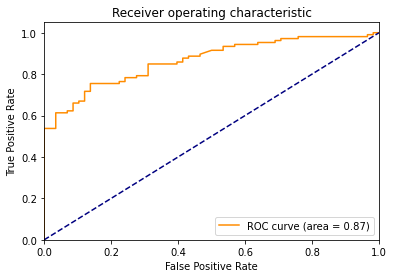

Optimal prediction threshold: 0.97599
Optimal prediction threshold: 0.99902
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.800
AUC for AD vs. CN = 0.942
Acc for MCI vs. CN = 67.8
Acc for AD vs. CN = 72.9
confusion matrix (naive)
[[31 27]
 [ 0  0]
 [10 47]
 [ 2 47]]
oAcc for MCI vs. CN = 73.0
oAcc for AD vs. CN = 89.7
confusion matrix (optimized)
[[50  8]
 [ 0  0]
 [23 34]
 [ 4 45]]
validating model newmodel/newmodel_wb_cv3.hdf5
Test accuracy: 75.61 %


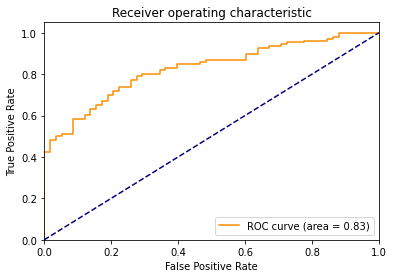

Optimal prediction threshold: 0.56678
Optimal prediction threshold: 0.98374
AUC for MCI vs. CN = 0.75
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.747
AUC for AD vs. CN = 0.919
Acc for MCI vs. CN = 67.8
Acc for AD vs. CN = 79.4
confusion matrix (naive)
[[39 19]
 [ 0  0]
 [18 39]
 [ 3 46]]
oAcc for MCI vs. CN = 68.7
oAcc for AD vs. CN = 86.0
confusion matrix (optimized)
[[41 17]
 [ 0  0]
 [19 38]
 [ 3 46]]
validating model newmodel/newmodel_wb_cv4.hdf5
Test accuracy: 77.44 %


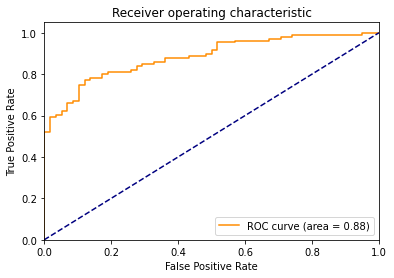

Optimal prediction threshold: 0.95314
Optimal prediction threshold: 0.99987
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.824
AUC for AD vs. CN = 0.954
Acc for MCI vs. CN = 70.4
Acc for AD vs. CN = 74.8
confusion matrix (naive)
[[34 24]
 [ 0  0]
 [10 47]
 [ 3 46]]
oAcc for MCI vs. CN = 74.8
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[47 11]
 [ 0  0]
 [18 39]
 [ 3 46]]
validating model newmodel/newmodel_wb_cv5.hdf5
Test accuracy: 79.88 %


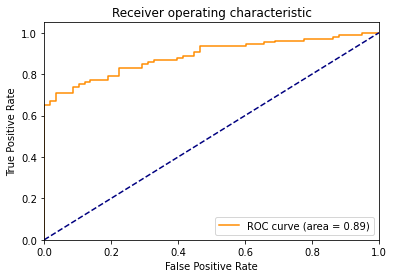

Optimal prediction threshold: 0.73796
Optimal prediction threshold: 0.99456
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.823
AUC for AD vs. CN = 0.963
Acc for MCI vs. CN = 73.0
Acc for AD vs. CN = 80.4
confusion matrix (naive)
[[39 19]
 [ 0  0]
 [12 45]
 [ 2 47]]
oAcc for MCI vs. CN = 75.7
oAcc for AD vs. CN = 91.6
confusion matrix (optimized)
[[45 13]
 [ 0  0]
 [15 42]
 [ 4 45]]
validating model newmodel/newmodel_wb_cv6.hdf5
Test accuracy: 80.49 %


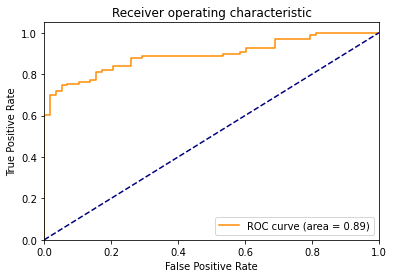

Optimal prediction threshold: 0.72295
Optimal prediction threshold: 0.99994
AUC for MCI vs. CN = 0.84
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.837
AUC for AD vs. CN = 0.956
Acc for MCI vs. CN = 74.8
Acc for AD vs. CN = 78.5
confusion matrix (naive)
[[38 20]
 [ 0  0]
 [ 9 48]
 [ 3 46]]
oAcc for MCI vs. CN = 77.4
oAcc for AD vs. CN = 93.5
confusion matrix (optimized)
[[43 15]
 [ 0  0]
 [11 46]
 [ 3 46]]
validating model newmodel/newmodel_wb_cv7.hdf5
Test accuracy: 74.39 %


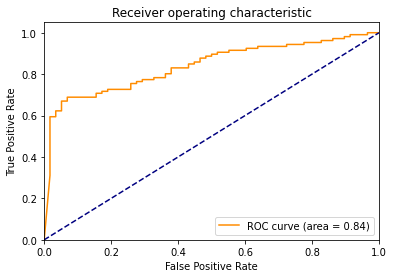

Optimal prediction threshold: 0.99216
Optimal prediction threshold: 0.99628
AUC for MCI vs. CN = 0.76
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.764
AUC for AD vs. CN = 0.927
Acc for MCI vs. CN = 67.8
Acc for AD vs. CN = 77.6
confusion matrix (naive)
[[39 19]
 [ 0  0]
 [18 39]
 [ 5 44]]
oAcc for MCI vs. CN = 71.3
oAcc for AD vs. CN = 91.6
confusion matrix (optimized)
[[54  4]
 [ 0  0]
 [29 28]
 [ 5 44]]
validating model newmodel/newmodel_wb_cv8.hdf5
Test accuracy: 78.05 %


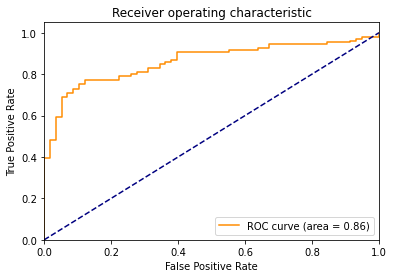

Optimal prediction threshold: 0.94464
Optimal prediction threshold: 0.94669
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.791
AUC for AD vs. CN = 0.942
Acc for MCI vs. CN = 71.3
Acc for AD vs. CN = 78.5
confusion matrix (naive)
[[38 20]
 [ 0  0]
 [13 44]
 [ 3 46]]
oAcc for MCI vs. CN = 75.7
oAcc for AD vs. CN = 88.8
confusion matrix (optimized)
[[51  7]
 [ 0  0]
 [21 36]
 [ 4 45]]
validating model newmodel/newmodel_wb_cv9.hdf5
Test accuracy: 78.05 %


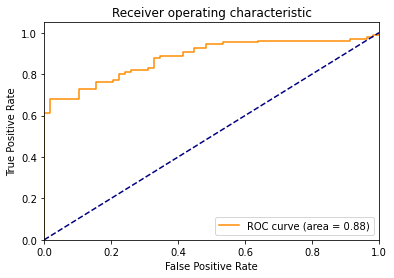

Optimal prediction threshold: 0.97177
Optimal prediction threshold: 0.97094
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.820
AUC for AD vs. CN = 0.951
Acc for MCI vs. CN = 71.3
Acc for AD vs. CN = 86.9
confusion matrix (naive)
[[47 11]
 [ 0  0]
 [22 35]
 [ 3 46]]
oAcc for MCI vs. CN = 74.8
oAcc for AD vs. CN = 91.6
confusion matrix (optimized)
[[57  1]
 [ 0  0]
 [28 29]
 [ 8 41]]
validating model newmodel/newmodel_wb_cv10.hdf5
Test accuracy: 76.83 %


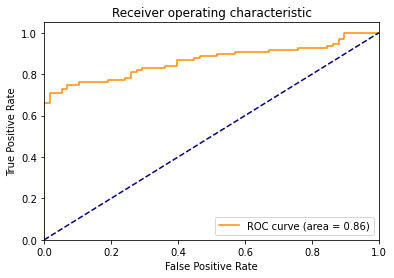

Optimal prediction threshold: 0.99680
Optimal prediction threshold: 0.99620
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.791
AUC for AD vs. CN = 0.950
Acc for MCI vs. CN = 69.6
Acc for AD vs. CN = 74.8
confusion matrix (naive)
[[34 24]
 [ 0  0]
 [11 46]
 [ 3 46]]
oAcc for MCI vs. CN = 75.7
oAcc for AD vs. CN = 93.5
confusion matrix (optimized)
[[57  1]
 [ 0  0]
 [27 30]
 [ 6 43]]
validating model newmodel/newmodel_wb_cv11.hdf5
Test accuracy: 77.44 %


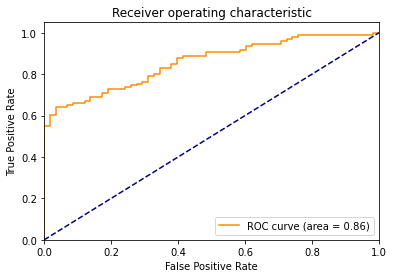

Optimal prediction threshold: 0.99898
Optimal prediction threshold: 0.99957
AUC for MCI vs. CN = 0.78
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.781
AUC for AD vs. CN = 0.944
Acc for MCI vs. CN = 70.4
Acc for AD vs. CN = 75.7
confusion matrix (naive)
[[35 23]
 [ 0  0]
 [11 46]
 [ 3 46]]
oAcc for MCI vs. CN = 70.4
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[56  2]
 [ 0  0]
 [32 25]
 [ 7 42]]
validating model newmodel/newmodel_wb_cv12.hdf5
Test accuracy: 79.27 %


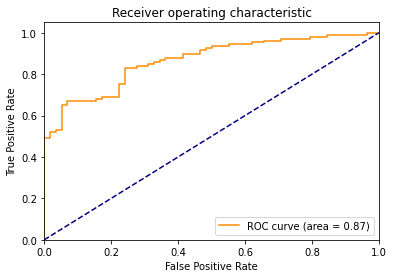

Optimal prediction threshold: 0.64042
Optimal prediction threshold: 0.98138
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.788
AUC for AD vs. CN = 0.957
Acc for MCI vs. CN = 73.0
Acc for AD vs. CN = 81.3
confusion matrix (naive)
[[41 17]
 [ 0  0]
 [14 43]
 [ 3 46]]
oAcc for MCI vs. CN = 73.9
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[44 14]
 [ 0  0]
 [16 41]
 [ 3 46]]
validating model newmodel/newmodel_wb_cv13.hdf5
Test accuracy: 76.22 %


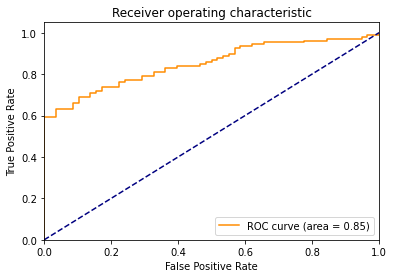

Optimal prediction threshold: 0.02999
Optimal prediction threshold: 0.94614
AUC for MCI vs. CN = 0.76
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.765
AUC for AD vs. CN = 0.949
Acc for MCI vs. CN = 70.4
Acc for AD vs. CN = 86.9
confusion matrix (naive)
[[49  9]
 [ 0  0]
 [25 32]
 [ 5 44]]
oAcc for MCI vs. CN = 70.4
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[44 14]
 [ 0  0]
 [20 37]
 [ 5 44]]
validating model newmodel/newmodel_wb_cv14.hdf5
Test accuracy: 81.71 %


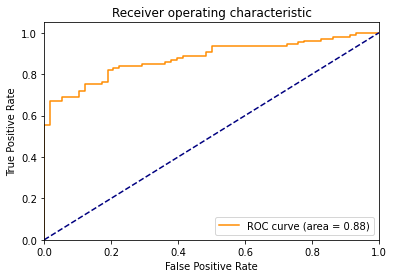

Optimal prediction threshold: 0.72038
Optimal prediction threshold: 0.99983
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.805
AUC for AD vs. CN = 0.963
Acc for MCI vs. CN = 76.5
Acc for AD vs. CN = 85.0
confusion matrix (naive)
[[45 13]
 [ 0  0]
 [14 43]
 [ 3 46]]
oAcc for MCI vs. CN = 76.5
oAcc for AD vs. CN = 92.5
confusion matrix (optimized)
[[47 11]
 [ 0  0]
 [16 41]
 [ 4 45]]
validating model newmodel/newmodel_wb_cv15.hdf5
Test accuracy: 75.00 %


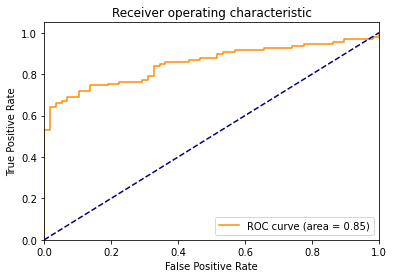

Optimal prediction threshold: 0.84232
Optimal prediction threshold: 0.99770
AUC for MCI vs. CN = 0.77
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.770
AUC for AD vs. CN = 0.947
Acc for MCI vs. CN = 67.0
Acc for AD vs. CN = 82.2
confusion matrix (naive)
[[42 16]
 [ 0  0]
 [22 35]
 [ 3 46]]
oAcc for MCI vs. CN = 71.3
oAcc for AD vs. CN = 92.5
confusion matrix (optimized)
[[50  8]
 [ 0  0]
 [25 32]
 [ 3 46]]
validating model newmodel/newmodel_wb_cv16.hdf5
Test accuracy: 75.61 %


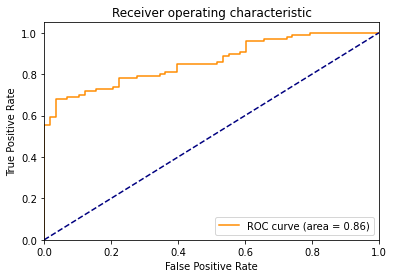

Optimal prediction threshold: 0.99472
Optimal prediction threshold: 0.99362
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.790
AUC for AD vs. CN = 0.946
Acc for MCI vs. CN = 68.7
Acc for AD vs. CN = 79.4
confusion matrix (naive)
[[40 18]
 [ 0  0]
 [18 39]
 [ 4 45]]
oAcc for MCI vs. CN = 73.0
oAcc for AD vs. CN = 91.6
confusion matrix (optimized)
[[56  2]
 [ 0  0]
 [29 28]
 [10 39]]
validating model newmodel/newmodel_wb_cv17.hdf5
Test accuracy: 76.22 %


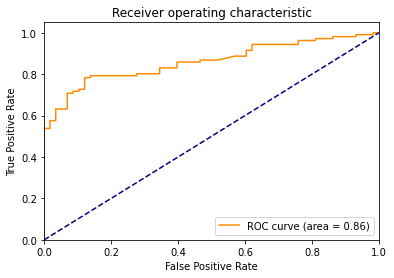

Optimal prediction threshold: 0.82880
Optimal prediction threshold: 0.98490
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.800
AUC for AD vs. CN = 0.933
Acc for MCI vs. CN = 70.4
Acc for AD vs. CN = 78.5
confusion matrix (naive)
[[40 18]
 [ 0  0]
 [16 41]
 [ 5 44]]
oAcc for MCI vs. CN = 77.4
oAcc for AD vs. CN = 90.7
confusion matrix (optimized)
[[50  8]
 [ 0  0]
 [18 39]
 [ 5 44]]
validating model newmodel/newmodel_wb_cv18.hdf5
Test accuracy: 79.27 %


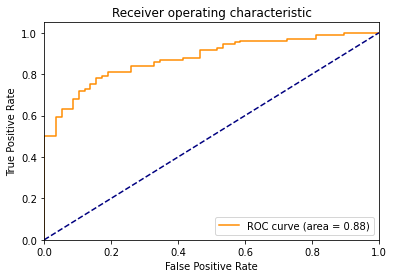

Optimal prediction threshold: 0.72745
Optimal prediction threshold: 0.99716
AUC for MCI vs. CN = 0.81
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.814
AUC for AD vs. CN = 0.951
Acc for MCI vs. CN = 73.0
Acc for AD vs. CN = 83.2
confusion matrix (naive)
[[43 15]
 [ 0  0]
 [16 41]
 [ 3 46]]
oAcc for MCI vs. CN = 75.7
oAcc for AD vs. CN = 89.7
confusion matrix (optimized)
[[47 11]
 [ 0  0]
 [17 40]
 [ 5 44]]
validating model newmodel/newmodel_wb_cv19.hdf5
Test accuracy: 73.17 %


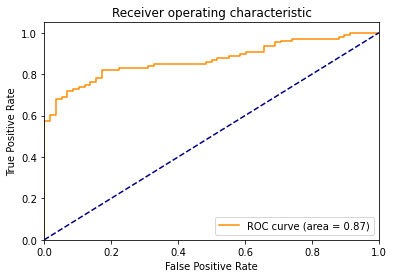

Optimal prediction threshold: 0.90513
Optimal prediction threshold: 0.99770
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.96
AUC for MCI vs. CN = 0.793
AUC for AD vs. CN = 0.960
Acc for MCI vs. CN = 63.5
Acc for AD vs. CN = 71.0
confusion matrix (naive)
[[29 29]
 [ 0  0]
 [13 44]
 [ 2 47]]
oAcc for MCI vs. CN = 75.7
oAcc for AD vs. CN = 91.6
confusion matrix (optimized)
[[48 10]
 [ 0  0]
 [18 39]
 [ 2 47]]
validating model newmodel/newmodel_wb_cv20.hdf5
Test accuracy: 82.93 %


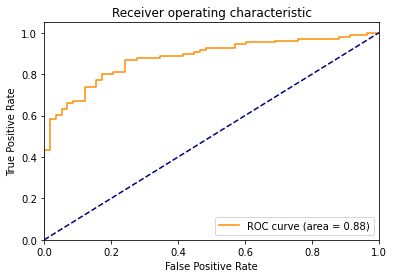

Optimal prediction threshold: 0.63339
Optimal prediction threshold: 0.99760
AUC for MCI vs. CN = 0.82
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.818
AUC for AD vs. CN = 0.950
Acc for MCI vs. CN = 77.4
Acc for AD vs. CN = 85.0
confusion matrix (naive)
[[44 14]
 [ 0  0]
 [12 45]
 [ 2 47]]
oAcc for MCI vs. CN = 76.5
oAcc for AD vs. CN = 89.7
confusion matrix (optimized)
[[44 14]
 [ 0  0]
 [13 44]
 [ 3 46]]


In [9]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

import keras
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.optimizers import Adam
from keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from statistics import mean,stdev
from sklearn.metrics import confusion_matrix

acc_test, auc_test, auc_AD, auc_MCI = [], [], [], []
acc_AD, acc_MCI, opt_acc_AD, opt_acc_MCI = [], [], [], []
grps['pred'] = np.nan #-1
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
opt_ppv_AD, opt_ppv_MCI, opt_npv_AD, opt_npv_MCI = [], [], [], []
opt_sen_AD, opt_sen_MCI, opt_spec_AD, opt_spec_MCI = [], [], [], []
f1_AD, f1_MCI, opt_f1_AD, opt_f1_MCI = [], [], [], []

num_kfold = 20 # number of cross-validation loops equal to number of models
batch_size = 8

for k in range(num_kfold):
    gc.collect()
    print('validating model newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    mymodel = models.load_model('newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    
    # Calculate accuracy for validation data
    #scores = mymodel.evaluate(images, labels, batch_size=batch_size) #, verbose=0
    #print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    #acc_test.append(scores[1]*100)
    test_idX = np.array(range(amy_filter.shape[1]))[np.squeeze(amy_filter)] # filter index vector by amy status
    testgrps = grps.iloc[test_idX, :]
    testdat = images[test_idX, :]
    test_Y = labels[test_idX, :]
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(testdat, batch_size=batch_size)
    grps.iloc[test_idX, 2] = pred[:, 1]
    acc_all = np.mean((test_Y[:, 1] == np.round(pred[:, 1])).astype(int))*100
    print("Test accuracy: %.2f %%" % acc_all)
    acc_test.append(acc_all)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    opt_acc = dict()
    thresh = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    auc_test.append(roc_auc[1])
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [2,5]:
      grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.zeros((testgrps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], thresholds = roc_curve(test_Y[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      thresh[i] = thresholds[np.argmax(tpr[i] - fpr[i])]
      print('Optimal prediction threshold: %0.5f' % thresh[i])
      acc[i] = np.mean((test_Y[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100
      opt_acc[i] = np.mean((test_Y[grpidx, 1] == (pred[grpidx, 1]>thresh[i]).astype(int)).astype(int))*100

    print('AUC for MCI vs. CN = %0.2f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.2f' % roc_auc[5])
    auc_AD.append(roc_auc[5])
    auc_MCI.append(roc_auc[2])
    acc_AD.append(acc[5])
    acc_MCI.append(acc[2])
    opt_acc_AD.append(opt_acc[5])
    opt_acc_MCI.append(opt_acc[2])
    
    print('AUC for MCI vs. CN = %0.3f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[5])
    print('Acc for MCI vs. CN = %0.1f' % acc[2])
    print('Acc for AD vs. CN = %0.1f' % acc[5])
    print('confusion matrix (naive)')
    confmat = confusion_matrix(testgrps.Group, np.round(pred[:, 1]))
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[:,(0,1)])
    print('oAcc for MCI vs. CN = %0.1f' % opt_acc[2])
    print('oAcc for AD vs. CN = %0.1f' % opt_acc[5])
    print('confusion matrix (optimized)')
    confmat = confusion_matrix(testgrps.Group, (pred[:, 1]>thresh[2]).astype(int)) ## use MCI threshold
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    opt_sen_MCI.append(sen); opt_spec_MCI.append(spec); opt_ppv_MCI.append(ppv); opt_npv_MCI.append(npv); opt_f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    opt_sen_AD.append(sen); opt_spec_AD.append(spec); opt_ppv_AD.append(ppv); opt_npv_AD.append(npv); opt_f1_AD.append(f1)
    print(confmat[:,(0,1)])

In [10]:
# print model performance summary
from statistics import mean,stdev
print('Acc for all test data = %0.1f +/- %0.1f' % (mean(acc_test), stdev(acc_test)))
print('AUC for all test data = %0.3f +/- %0.3f' % (mean(auc_test), stdev(auc_test)))
print('AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.1f +/- %0.1f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean oAcc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_MCI), stdev(opt_acc_MCI)))
print('Mean oAcc for AD vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_AD), stdev(opt_acc_AD)))

fpr_all, tpr_all, thresholds_all = roc_curve(labels[np.isfinite(grps.pred), 1], grps.pred[np.isfinite(grps.pred)])
thresh_all = thresholds_all[np.argmax(tpr_all - fpr_all)]
print(thresh_all)
roc_auc_all = auc(fpr_all, tpr_all)
acc_all = np.mean((labels[np.isfinite(grps.pred), 1] == np.round(grps.pred[np.isfinite(grps.pred)])).astype(int))*100
opt_acc_all = np.mean((labels[np.isfinite(grps.pred), 1] == (grps.pred[np.isfinite(grps.pred)]>thresh_all).astype(int)).astype(int))*100

confmat = confusion_matrix(grps.Group[np.isfinite(grps.pred)]-1, (grps.pred[np.isfinite(grps.pred)]>thresh_all).astype(int))
print('Naive accuracy: %0.1f %%' % acc_all)
print('confusion matrix (naive)')
print(confusion_matrix(grps.Group[np.isfinite(grps.pred)]-1, np.round(grps.pred[np.isfinite(grps.pred)]))[:,(1,2)])

print('Optimized accuracy: %0.1f %%' % opt_acc_all)
print('confusion matrix (optimized)')
print(confmat[:,(1,2)])

Acc for all test data = 77.4 +/- 2.5
AUC for all test data = 0.866 +/- 0.016
AUC for MCI vs. CN = 0.796 +/- 0.023
AUC for AD vs. CN = 0.947 +/- 0.012
Mean Acc for MCI vs. CN = 70.6 +/- 3.4
Mean Acc for AD vs. CN = 79.2 +/- 4.8
Mean oAcc for MCI vs. CN = 74.1 +/- 2.5
Mean oAcc for AD vs. CN = 90.9 +/- 1.7
0.9362806081771851
Naive accuracy: 82.9 %
confusion matrix (naive)
[[44 14]
 [ 0  0]
 [12 45]
 [ 2 47]]
Optimized accuracy: 80.5 %
confusion matrix (optimized)
[[48 10]
 [ 0  0]
 [18 39]
 [ 4 45]]


In [11]:
results = pd.DataFrame({'Accuracy_Test':acc_test, 'AUC_Test':auc_test, 'AUC_MCI':auc_MCI, 'AUC_AD':auc_AD,
                        'Acc_MCI':acc_MCI, 'Acc_AD':acc_AD,
                        'Opt_acc_MCI':opt_acc_MCI, 'Opt_acc_AD':opt_acc_AD})
print(results)

    Accuracy_Test  AUC_Test   AUC_MCI    AUC_AD    Acc_MCI     Acc_AD  \
0       75.000000  0.864183  0.805203  0.932794  66.956522  71.962617   
1       76.219512  0.865485  0.800060  0.941590  67.826087  72.897196   
2       75.609756  0.826448  0.746521  0.919423  67.826087  79.439252   
3       77.439024  0.884190  0.824259  0.953906  70.434783  74.766355   
4       79.878049  0.887606  0.823049  0.962702  73.043478  80.373832   
5       80.487805  0.892323  0.837266  0.956369  74.782609  78.504673   
6       74.390244  0.839541  0.764368  0.926988  67.826087  77.570093   
7       78.048780  0.860930  0.790986  0.942294  71.304348  78.504673   
8       78.048780  0.880612  0.819722  0.951443  71.304348  86.915888   
9       76.829268  0.864834  0.791289  0.950387  69.565217  74.766355   
10      77.439024  0.856213  0.780702  0.944053  70.434783  75.700935   
11      79.268293  0.865810  0.787659  0.956721  73.043478  81.308411   
12      76.219512  0.849870  0.764973  0.948628  70

In [12]:
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean oSen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_MCI), stdev(opt_sen_MCI)))
print('Mean oSen for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_AD), stdev(opt_sen_AD)))

print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean oSpec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_MCI), stdev(opt_spec_MCI)))
print('Mean oSpec for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_AD), stdev(opt_spec_AD)))

print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean oPPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_MCI), stdev(opt_ppv_MCI)))
print('Mean oPPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_AD), stdev(opt_ppv_AD)))

print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean oNPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_MCI), stdev(opt_npv_MCI)))
print('Mean oNPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_AD), stdev(opt_npv_AD)))

print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))
print('Mean oF1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_MCI), stdev(opt_f1_MCI)))
print('Mean oF1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_AD), stdev(opt_f1_AD)))

Mean Sen for MCI vs. CN = 0.741 +/- 0.079
Mean Sen for AD vs. CN = 0.936 +/- 0.019
Mean oSen for MCI vs. CN = 0.631 +/- 0.105
Mean oSen for AD vs. CN = 0.905 +/- 0.040
Mean Spec for MCI vs. CN = 0.671 +/- 0.093
Mean Spec for AD vs. CN = 0.671 +/- 0.093
Mean oSpec for MCI vs. CN = 0.850 +/- 0.088
Mean oSpec for AD vs. CN = 0.850 +/- 0.088
Mean PPV for MCI vs. CN = 0.694 +/- 0.048
Mean PPV for AD vs. CN = 0.711 +/- 0.058
Mean oPPV for MCI vs. CN = 0.822 +/- 0.082
Mean oPPV for AD vs. CN = 0.846 +/- 0.081
Mean NPV for MCI vs. CN = 0.729 +/- 0.044
Mean NPV for AD vs. CN = 0.925 +/- 0.018
Mean oNPV for MCI vs. CN = 0.706 +/- 0.043
Mean oNPV for AD vs. CN = 0.916 +/- 0.026
Mean F1 for MCI vs. CN = 0.695 +/- 0.041
Mean F1 for AD vs. CN = 0.777 +/- 0.062
Mean oF1 for MCI vs. CN = 0.713 +/- 0.048
Mean oF1 for AD vs. CN = 0.873 +/- 0.035
